In [ ]:
import sklearn
import pandas as pd
import numpy as np
from deep_translator import GoogleTranslator
import xgboost as xgb
import matplotlib.pyplot as plt
import re
#import text2vec

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Create an empty DataFrame with the specified columns

columns = ['body', 'id','subreddit', 'body_NO_PUNC', 'fentanyl',
'count_fentanyl', 'heroin', 'count_heroin', 'oxy', 'count_oxy', 'MDMA',
'count_MDMA', 'INHALANTS', 'count_INHALANTS', 'GHB', 'count_GHB',
'COCAINE', 'count_COCAINE', 'marijuana', 'count_marijuana',
'total_flags', 'match', 'total_text_no_punc', 'total_text',
'concat', 'total_no_drug', 'year']


balanced_sample = pd.DataFrame(columns=columns)
no_included_samples = pd.DataFrame(columns=columns)


In [ ]:
def balanced_sample_maker(csv, balanced, left_overs, un_balancer):
    file_path_submission = csv
    columns_to_read = ['body', 'id','subreddit', 'body_NO_PUNC', 'fentanyl',
       'count_fentanyl', 'heroin', 'count_heroin', 'oxy', 'count_oxy', 'MDMA',
       'count_MDMA', 'INHALANTS', 'count_INHALANTS', 'GHB', 'count_GHB',
       'COCAINE', 'count_COCAINE', 'marijuana', 'count_marijuana',
       'total_flags', 'match']

    submissions = pd.read_csv(file_path_submission, usecols=columns_to_read)
    submissions['year'] = file_path_submission[-11:-7]

    #submissions['country'] = submissions['subreddit'].map(dictionary)
    #submissions = submissions[submissions['no_match'] == 0]
    #submissions['match'] = np.where(submissions['no_match'] == 0, 1,0)

    #submissions['match'] = submissions['no_match']
    submissions[submissions['body'] != '[removed]']

    submissions['body'] = submissions['body'].fillna(' ')

    submissions['body_NO_PUNC'] = submissions['body_NO_PUNC'].fillna(' ')

    #submissions change this to be rename
    submissions = submissions.rename(columns={"body_NO_PUNC": "total_text_no_punc", "body": "total_text"})
    #print(submissions.columns)

    submissions = submissions[~submissions['total_text'].str.contains('\[removed\]', case=False)]
    submissions = submissions[~submissions['total_text'].str.contains('\[deleted\]', case=False)]
    removed_pattern = re.compile(r'\[r(e|m)(o|0)v(e|a)ed\]', flags=re.IGNORECASE)
# Filter out rows containing '[removed]' variations in the 'total_text' column
    submissions = submissions[~submissions['total_text'].str.extract(removed_pattern).notna().any(axis=1)]

    lst = submissions.columns.tolist()

    # Splitting column names by commas and flattening the resulting list
    split_columns = [item.split(',') for item in lst]
    flattened_list = [item for sublist in split_columns for item in sublist]

    filtered_list = [item for item in flattened_list[flattened_list.index('total_text_no_punc') + 1:]]
    filtered_list = [item for item in filtered_list if "count_" not in item]
    filtered_list = [item for item in filtered_list[:filtered_list.index('total_flags'):]]

    submissions['concat'] = submissions[filtered_list].values.tolist()

    submissions['concat'] = submissions['concat'].apply(lambda x: [item for item in x if pd.notna(item)])

    submissions['concat'] = submissions['concat'].apply(lambda x: [item.strip() for sublist in x for item in sublist.split(',')] if x else [])

    def remove_occurrences(row):
        for item in row['concat']:
            # Create a regular expression pattern for whole-word match with case-insensitive flag
            pattern = r'\b{}\b'.format(re.escape(item))
            # Use re.sub to replace occurrences based on the pattern
            row['total_text_no_punc'] = re.sub(pattern, '', row['total_text_no_punc'], flags=re.IGNORECASE)
        return row['total_text_no_punc']

    # Apply the function to each row
    submissions['total_no_drug'] = submissions.apply(remove_occurrences, axis=1)

    def compbl(s):
        return ' '.join(s.split())

    submissions['total_no_drug'] = submissions['total_no_drug'].apply(compbl)


    drug_summary = submissions.columns.tolist()
    count_columns = [col for col in drug_summary if col.startswith('count_')]
    #submissions = submissions[submissions['total_text'].str.contains(re.escape('[removed]'))]
    n = int(round(submissions['match'].sum() * un_balancer))
    sample_no_drug = submissions[submissions['match'] == 0].sample(n)
    not_selected_samples = submissions[~submissions.index.isin(sample_no_drug.index)]
    #keeping not included samples
    sample_drug = submissions[submissions['match'] == 1]
    balanced = pd.concat([sample_drug,sample_no_drug], ignore_index = True)

    print("total drug related content {}, total length of balanced dataset {}".format(submissions['match'].sum(), len(balanced)))
    return balanced, not_selected_samples


In [ ]:
#import glob
#folder = 'C:/Users/Jonathon/OneDrive/UVA/Data System Project/reddit_csv/comment/cleaned_matched'
#for x in glob.glob('{}\*.csv'.format(folder)):
#    bal, ns = balanced_sample_maker(x,
#                          balanced_sample,
#                         no_included_samples,
#                         1.3)
#    no_included_samples = pd.concat([no_included_samples,ns], ignore_index = True)
#    balanced_sample = pd.concat([balanced_sample, bal], ignore_index = True)


total drug related content 9, total length of balanced dataset 21


C:\Users\Jonathon\AppData\Local\Temp\ipykernel_3564\1504648144.py:9: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pd.read_csv(file_path_submission, usecols=columns_to_read)


total drug related content 10768, total length of balanced dataset 24766


C:\Users\Jonathon\AppData\Local\Temp\ipykernel_3564\1504648144.py:9: DtypeWarning: Columns (10,12,14,16,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pd.read_csv(file_path_submission, usecols=columns_to_read)


total drug related content 10168, total length of balanced dataset 23386


C:\Users\Jonathon\AppData\Local\Temp\ipykernel_3564\1504648144.py:9: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pd.read_csv(file_path_submission, usecols=columns_to_read)


total drug related content 13715, total length of balanced dataset 31545


C:\Users\Jonathon\AppData\Local\Temp\ipykernel_3564\1504648144.py:9: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pd.read_csv(file_path_submission, usecols=columns_to_read)


total drug related content 12482, total length of balanced dataset 28709


C:\Users\Jonathon\AppData\Local\Temp\ipykernel_3564\1504648144.py:9: DtypeWarning: Columns (16,18,20,22) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pd.read_csv(file_path_submission, usecols=columns_to_read)


total drug related content 13383, total length of balanced dataset 30781


C:\Users\Jonathon\AppData\Local\Temp\ipykernel_3564\1504648144.py:9: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pd.read_csv(file_path_submission, usecols=columns_to_read)


total drug related content 12708, total length of balanced dataset 29228


C:\Users\Jonathon\AppData\Local\Temp\ipykernel_3564\1504648144.py:9: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pd.read_csv(file_path_submission, usecols=columns_to_read)


total drug related content 13390, total length of balanced dataset 30797


C:\Users\Jonathon\AppData\Local\Temp\ipykernel_3564\1504648144.py:9: DtypeWarning: Columns (18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pd.read_csv(file_path_submission, usecols=columns_to_read)


total drug related content 13005, total length of balanced dataset 29911


C:\Users\Jonathon\AppData\Local\Temp\ipykernel_3564\1504648144.py:9: DtypeWarning: Columns (18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pd.read_csv(file_path_submission, usecols=columns_to_read)


total drug related content 12673, total length of balanced dataset 29148


C:\Users\Jonathon\AppData\Local\Temp\ipykernel_3564\1504648144.py:9: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pd.read_csv(file_path_submission, usecols=columns_to_read)


total drug related content 14903, total length of balanced dataset 34277


C:\Users\Jonathon\AppData\Local\Temp\ipykernel_3564\1504648144.py:9: DtypeWarning: Columns (18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pd.read_csv(file_path_submission, usecols=columns_to_read)


total drug related content 14059, total length of balanced dataset 32336


C:\Users\Jonathon\AppData\Local\Temp\ipykernel_3564\1504648144.py:9: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pd.read_csv(file_path_submission, usecols=columns_to_read)


total drug related content 15138, total length of balanced dataset 34817


C:\Users\Jonathon\AppData\Local\Temp\ipykernel_3564\1504648144.py:9: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pd.read_csv(file_path_submission, usecols=columns_to_read)


total drug related content 16254, total length of balanced dataset 37384


C:\Users\Jonathon\AppData\Local\Temp\ipykernel_3564\1504648144.py:9: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pd.read_csv(file_path_submission, usecols=columns_to_read)


total drug related content 14457, total length of balanced dataset 33251


C:\Users\Jonathon\AppData\Local\Temp\ipykernel_3564\1504648144.py:9: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pd.read_csv(file_path_submission, usecols=columns_to_read)


total drug related content 15810, total length of balanced dataset 36363


C:\Users\Jonathon\AppData\Local\Temp\ipykernel_3564\1504648144.py:9: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pd.read_csv(file_path_submission, usecols=columns_to_read)


total drug related content 16817, total length of balanced dataset 38679


C:\Users\Jonathon\AppData\Local\Temp\ipykernel_3564\1504648144.py:9: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pd.read_csv(file_path_submission, usecols=columns_to_read)


total drug related content 15286, total length of balanced dataset 35158


C:\Users\Jonathon\AppData\Local\Temp\ipykernel_3564\1504648144.py:9: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pd.read_csv(file_path_submission, usecols=columns_to_read)


total drug related content 13374, total length of balanced dataset 30760


C:\Users\Jonathon\AppData\Local\Temp\ipykernel_3564\1504648144.py:9: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pd.read_csv(file_path_submission, usecols=columns_to_read)


total drug related content 14517, total length of balanced dataset 33389


C:\Users\Jonathon\AppData\Local\Temp\ipykernel_3564\1504648144.py:9: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pd.read_csv(file_path_submission, usecols=columns_to_read)


total drug related content 16046, total length of balanced dataset 36906


C:\Users\Jonathon\AppData\Local\Temp\ipykernel_3564\1504648144.py:9: DtypeWarning: Columns (10,12,20) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pd.read_csv(file_path_submission, usecols=columns_to_read)


total drug related content 18806, total length of balanced dataset 43254


C:\Users\Jonathon\AppData\Local\Temp\ipykernel_3564\1504648144.py:9: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pd.read_csv(file_path_submission, usecols=columns_to_read)


total drug related content 17612, total length of balanced dataset 40508


MemoryError: Unable to allocate 169. MiB for an array with shape (1, 22214670) and data type object

In [ ]:
no_included_samples = pd.read_csv('/content/drive/MyDrive/reddit/reddit clean/no_include_sample_comm.csv')

In [ ]:
balanced_sample = pd.read_csv('/content/drive/MyDrive/reddit/reddit clean/balance_sample_comm.csv')


reduction_percentage = 0.5
n_noD =  round(len(balanced_sample[balanced_sample['match'] == 0]) * reduction_percentage)
n_D = round(len(balanced_sample[balanced_sample['match'] == 1]) * reduction_percentage)

balanced_sample1 = balanced_sample[balanced_sample['match'] == 1].sample(n=n_D, random_state=1)
balanced_sample2 = balanced_sample[balanced_sample['match'] == 0].sample(n=n_noD, random_state=1)

balanced_sample = pd.concat([balanced_sample1,balanced_sample2])


,body,id,subreddit,body_NO_PUNC,fentanyl,count_fentanyl,heroin,count_heroin,oxy,count_oxy,...,count_COCAINE,marijuana,count_marijuana,total_flags,match,total_text_no_punc,total_text,concat,total_no_drug,year
0,NaN,f973k7s,CasualUK,NaN,NaN,0,NaN,0,NaN,0,...,1,NaN,0,1,1,The little bit of Sheffield mileage I do ive n...,The little bit of Sheffield mileage I do ive n...,[Bump],The little bit of Sheffield mileage I do ive n...,2019
1,NaN,f973zsm,uktrees,NaN,NaN,0,NaN,0,NaN,0,...,0,weed,1,1,1,Weed Mecca,Weed Mecca.,[weed],Mecca,2019
2,NaN,f9755vx,poland,NaN,NaN,0,NaN,0,NaN,0,...,1,NaN,0,1,1,Sanatorium - Taco Hemingway Schafter - Blow Of...,"Sanatorium - Taco Hemingway,Schafter - Blow Of...",[Blow],Sanatorium - Taco Hemingway Schafter - Off Tra...,2019
3,NaN,f975boh,CasualUK,NaN,NaN,0,NaN,0,NaN,0,...,0,tree,1,1,1,Tree Fiddy,Tree Fiddy,[tree],Fiddy,2019
4,NaN,f975pt2,CasualUK,NaN,NaN,0,NaN,0,NaN,0,...,0,tree,1,1,1,It’s the first year where we are doing elf on ...,It’s the first year where we are doing elf on ...,[tree],It’s the first year where we are doing elf on ...,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660413,NaN,hewuqbn,de,NaN,NaN,0,NaN,0,NaN,0,...,0,cannabis,1,1,1,Das ist so nicht korrekt Die Drogenfahrt berü...,Das ist so nicht korrekt. Die Drogenfahrt berü...,[cannabis],Das ist so nicht korrekt Die Drogenfahrt berüc...,2021
660414,NaN,hewvydy,belgium,NaN,NaN,0,NaN,0,NaN,0,...,1,NaN,0,1,1,Quick question I might go later Jan-Feb for ...,"Quick question,I might go later (Jan-Feb) for ...",[Snow],Quick question I might go later Jan-Feb for sa...,2021
660415,NaN,hewwip2,uktrees,NaN,NaN,0,NaN,0,NaN,0,...,0,weed,1,1,1,What strain is that bud of weed that's picture...,What strain is that bud of weed that's picture...,[weed],What strain is that bud of that's pictured on ...,2021
660416,NaN,hewxgbm,CasualUK,NaN,NaN,0,NaN,0,NaN,0,...,0,"grass, trees",2,2,1,I've done a lot on the garden over summer Bee...,I've done a lot on the garden over summer. Bee...,"[grass, trees]",I've done a lot on the garden over summer Been...,2021


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, classification_report

# Sample data - replace this with your own dataset
texts = balanced_sample['total_text'].tolist()

labels = balanced_sample['match'].tolist()

# Unpack and create a single list
#flat_list = sorted(set([item for subset in labels for item in subset]))

# Convert the list to a set to remove duplicates and then sort it
#sorted_unique_list = sorted(set(flat_list))


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)
#X_train

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train a Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vec, y_train)

# Make predictions on the test set
y_pred_bin = nb_classifier.predict(X_test_vec)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred_bin)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred_bin, zero_division=1))
# labels = ['count_COCAINE', 'count_INHALANTS', 'count_MDMA', 'count_fentanyl', 'count_heroin', 'count_marijuana', 'count_oxy', 'no_match']
#target_names = sorted_unique_list

Accuracy: 0.82
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.77      0.84     11420
           1       0.72      0.89      0.80      7521

    accuracy                           0.82     18941
   macro avg       0.82      0.83      0.82     18941
weighted avg       0.84      0.82      0.82     18941



In [ ]:
#no_included_samples
no_sample_pre = no_included_samples['total_text'].tolist()
no_sample_pre_vec = vectorizer.transform(no_sample_pre)
no_sample_predictions = nb_classifier.predict(no_sample_pre_vec)


In [ ]:
no_included_samples['prediction_NB'] = no_sample_predictions


In [ ]:
no_included_samples['prediction_NB'].mean()

0.25023081436158034

In [ ]:
not_match = no_included_samples[no_included_samples['match'] != no_included_samples['prediction']]
not_match

,Unnamed: 0,author,id,selftext,subreddit,subreddit_id,title,Country,selftext_NO_PUNC,title_NO_PUNC,...,marijuana,count_marijuana,total_flags,match,total_text_no_punc,total_text,concat,total_no_drug,year,prediction
1,3,meteoritee,eiazxp,Happy New Year 2020!Not only do we celebrate t...,CasualUK,t5_3j2jr,Happy New Year 2020!,UK,Happy New Year 2020 Not only do we celebrate t...,Happy New Year 2020,...,NaN,0,0,0,Happy New Year 2020 Happy New Year 2020 Not on...,Happy New Year 2020! Happy New Year 2020!Not o...,[],Happy New Year 2020 Happy New Year 2020 Not on...,2020,1
3,9,Rizlem,eib099,"I hope you have a happy new year, and your nex...",unitedkingdom,t5_2qhqb,HAPPY NEW YEAR!,UK,I hope you have a happy new year and your nex...,HAPPY NEW YEAR,...,NaN,0,0,0,HAPPY NEW YEAR I hope you have a happy new yea...,HAPPY NEW YEAR! I hope you have a happy new ye...,[],HAPPY NEW YEAR I hope you have a happy new yea...,2020,1
4,10,Arculae,eib0d0,,uktrees,t5_2si9d,Happy New Year,uk,,Happy New Year,...,NaN,0,0,0,Happy New Year,Happy New Year,[],Happy New Year,2020,1
13,34,DaSaYaMa,eib3vb,"Bei uns in der Straße, Anliegerstraße und sehr...",de,t5_22i0,Ich hatte meinen deutschesten Moment des Jahre...,Germany,Bei uns in der Straße Anliegerstraße und sehr...,Ich hatte meinen deutschesten Moment des Jahre...,...,NaN,0,0,0,Ich hatte meinen deutschesten Moment des Jahre...,Ich hatte meinen deutschesten Moment des Jahre...,[],Ich hatte meinen deutschesten Moment des Jahre...,2020,1
14,42,Fizzy47,eib5rp,,unitedkingdom,t5_2qhqb,Happy new years London!,UK,,Happy new years London,...,NaN,0,0,0,Happy new years London,Happy new years London!,[],Happy new years London,2020,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319218,46417,cyberoscar,16wl6aq,Jag inser att detta bara är en i mängden posts...,sweden,t5_2qofe,Min Take,Sweden,Jag inser att detta bara är en i mängden posts...,Min Take,...,cannabis,1,1,1,Min Take Jag inser att detta bara är en i mäng...,Min Take Jag inser att detta bara är en i mäng...,[cannabis],Min Take Jag inser att detta bara är en i mäng...,2023,0
1319226,46428,Zattlaegott,16wlg27,hej jag och en polare är extremt sugna på att ...,droger,t5_r5ugy,Hej någon som har har testat dmt och kan berät...,danish,hej jag och en polare är extremt sugna på att ...,Hej någon som har har testat dmt och kan berät...,...,NaN,0,0,0,Hej någon som har har testat dmt och kan berät...,Hej någon som har har testat dmt och kan berät...,[],Hej någon som har har testat dmt och kan berät...,2023,1
1319233,46437,Snopptorp,16wlt3z,mina föräldrar Cathca mig på att dricka men ja...,droger,t5_r5ugy,syns 6 bloss på piss,danish,mina föräldrar Cathca mig på att dricka men ja...,syns 6 bloss på piss,...,NaN,0,0,0,syns 6 bloss på piss mina föräldrar Cathca mig...,syns 6 bloss på piss mina föräldrar Cathca mig...,[],syns 6 bloss på piss mina föräldrar Cathca mig...,2023,1
1319237,46443,Julial12,16wlxmr,,CasualUK,t5_3j2jr,Home alone here 😪,UK,,Home alone here 😪,...,NaN,0,0,0,Home alone here 😪,Home alone here 😪,[],Home alone here 😪,2023,1


In [ ]:
#list(set(not_match['subreddit']))

#filter_list = ['Crainn','uktrees','droger','SwissTrees', 'SwissTrees',
# 'sweden',
# 'uktreesmeets',
# 'ResearchChemicalsNL',
# 'PsychonautDE',
# 'ResearchChemicalsFR',
# 'AmsterdamEnts',
# 'EdinburghTrees',
# 'CoedCymru']

# Filter the DataFrame
#not_match = not_match[not_match['subreddit'].isin(filter_list)]


In [ ]:
#not_match.to_csv(r"C:\Users\Jonathon\OneDrive\UVA\Data System Project\reddit_csv\hmm2.csv")

In [ ]:
#balanced_sample2 = balanced_sample.groupby('match').sample(frac=.70)


66293

In [ ]:
balanced_sample2.columns

Index(['Unnamed: 0', 'author', 'id', 'selftext', 'subreddit', 'subreddit_id',
       'title', 'Country', 'selftext_NO_PUNC', 'title_NO_PUNC', 'fentanyl',
       'count_fentanyl', 'heroin', 'count_heroin', 'oxy', 'count_oxy', 'MDMA',
       'count_MDMA', 'INHALANTS', 'count_INHALANTS', 'GHB', 'count_GHB',
       'COCAINE', 'count_COCAINE', 'marijuana', 'count_marijuana',
       'total_flags', 'match', 'total_text_no_punc', 'total_text', 'concat',
       'total_no_drug', 'year'],
      dtype='object')

In [ ]:
#balanced_sample2[['id', 'selftext', 'subreddit','Country',
#       'total_flags', 'match',  'total_text', 'concat',
#       'total_no_drug', 'year']].to_csv(r"C:\Users\Jonathon\OneDrive\UVA\Data System Project\reddit_csv\hmm2.csv")

In [ ]:
!pip uninstall xgboost
!pip install xgboost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
import cupy as cp

# Sample data - replace this with your own dataset
texts = balanced_sample['total_no_drug'].tolist()
labels = balanced_sample['match'].tolist()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Convert text data to numerical vectors using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Create an XGBoost model with GPU support
params = {
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',  # Use GPU for tree construction
}

xgb_model = xgb.XGBClassifier(**params)

# Fit the model on the training data
xgb_model.fit(X_train_vec, y_train)

# Make predictions on the test data
y_pred = xgb_model.predict(X_test_vec)

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall}')

# Define parameter grid for grid search
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='recall', cv=3)

# Fit the grid search on the training data
grid_search.fit(X_train_vec, y_train)

# Get the best parameters and the best model from the grid search
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test data using the tuned model
y_pred_tuned = best_model.predict(X_test_vec)

# Calculate recall for the tuned model
recall_tuned = recall_score(y_test, y_pred_tuned)
print(f'Tuned Recall: {recall_tuned}')

# Use CuPy for GPU-accelerated prediction
no_sample_pre = no_included_samples['total_text'].tolist()
no_sample_pre_vec = vectorizer.transform(no_sample_pre)
check = cp.array(best_model.predict(no_sample_pre_vec))
no_included_samples['xg_boost'] = check.get()

# Display results
not_match = no_included_samples[no_included_samples['match'] != no_included_samples['xg_boost']]
not_match = not_match[not_match['match'] != 1]
not_match


Precision: 0.5823429541595926
Tuned Precision: 0.8623268698060942


,Unnamed: 0,author,id,selftext,subreddit,subreddit_id,title,Country,selftext_NO_PUNC,title_NO_PUNC,...,count_marijuana,total_flags,match,total_text_no_punc,total_text,concat,total_no_drug,year,prediction,xg_boost
1,3,meteoritee,eiazxp,Happy New Year 2020!Not only do we celebrate t...,CasualUK,t5_3j2jr,Happy New Year 2020!,UK,Happy New Year 2020 Not only do we celebrate t...,Happy New Year 2020,...,0,0,0,Happy New Year 2020 Happy New Year 2020 Not on...,Happy New Year 2020! Happy New Year 2020!Not o...,[],Happy New Year 2020 Happy New Year 2020 Not on...,2020,1,1
13,34,DaSaYaMa,eib3vb,"Bei uns in der Straße, Anliegerstraße und sehr...",de,t5_22i0,Ich hatte meinen deutschesten Moment des Jahre...,Germany,Bei uns in der Straße Anliegerstraße und sehr...,Ich hatte meinen deutschesten Moment des Jahre...,...,0,0,0,Ich hatte meinen deutschesten Moment des Jahre...,Ich hatte meinen deutschesten Moment des Jahre...,[],Ich hatte meinen deutschesten Moment des Jahre...,2020,1,1
14,42,Fizzy47,eib5rp,,unitedkingdom,t5_2qhqb,Happy new years London!,UK,,Happy new years London,...,0,0,0,Happy new years London,Happy new years London!,[],Happy new years London,2020,1,1
15,44,Space-manatee,eib5un,,CasualUK,t5_3j2jr,People trying to see the London New Years’ fir...,UK,,People trying to see the London New Years’ fir...,...,0,0,0,People trying to see the London New Years’ fir...,People trying to see the London New Years’ fir...,[],People trying to see the London New Years’ fir...,2020,1,1
19,52,jamesg007,eib6vm,Hi there—I just moved to Luxembourg today (31 ...,Luxembourg,t5_2ryqf,"Local listings, like Yelp for Luxembourg?",Luxembourg,Hi there—I just moved to Luxembourg today 31 ...,Local listings like Yelp for Luxembourg,...,0,0,0,Local listings like Yelp for Luxembourg Hi th...,"Local listings, like Yelp for Luxembourg? Hi t...",[],Local listings like Yelp for Luxembourg Hi the...,2020,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319214,46413,Renordic,16wkz91,,germantrees,t5_2tcsn,Smoking time 🔥💨,germany,,Smoking time 🔥💨,...,0,0,0,Smoking time 🔥💨,Smoking time 🔥💨,[],Smoking time 🔥💨,2023,1,1
1319215,46414,AfraidFerret2605,16wl0m1,Ich habe mir schon 3 Mal Schuhe bei Zara gekau...,germany,t5_2qi4z,Zara Schuhe piepen,Germany,Ich habe mir schon 3 Mal Schuhe bei Zara gekau...,Zara Schuhe piepen,...,0,0,0,Zara Schuhe piepen Ich habe mir schon 3 Mal Sc...,Zara Schuhe piepen Ich habe mir schon 3 Mal Sc...,[],Zara Schuhe piepen Ich habe mir schon 3 Mal Sc...,2023,1,1
1319226,46428,Zattlaegott,16wlg27,hej jag och en polare är extremt sugna på att ...,droger,t5_r5ugy,Hej någon som har har testat dmt och kan berät...,danish,hej jag och en polare är extremt sugna på att ...,Hej någon som har har testat dmt och kan berät...,...,0,0,0,Hej någon som har har testat dmt och kan berät...,Hej någon som har har testat dmt och kan berät...,[],Hej någon som har har testat dmt och kan berät...,2023,1,1
1319233,46437,Snopptorp,16wlt3z,mina föräldrar Cathca mig på att dricka men ja...,droger,t5_r5ugy,syns 6 bloss på piss,danish,mina föräldrar Cathca mig på att dricka men ja...,syns 6 bloss på piss,...,0,0,0,syns 6 bloss på piss mina föräldrar Cathca mig...,syns 6 bloss på piss mina föräldrar Cathca mig...,[],syns 6 bloss på piss mina föräldrar Cathca mig...,2023,1,1


Text(0.5, 0, 'Feature Importance Score')

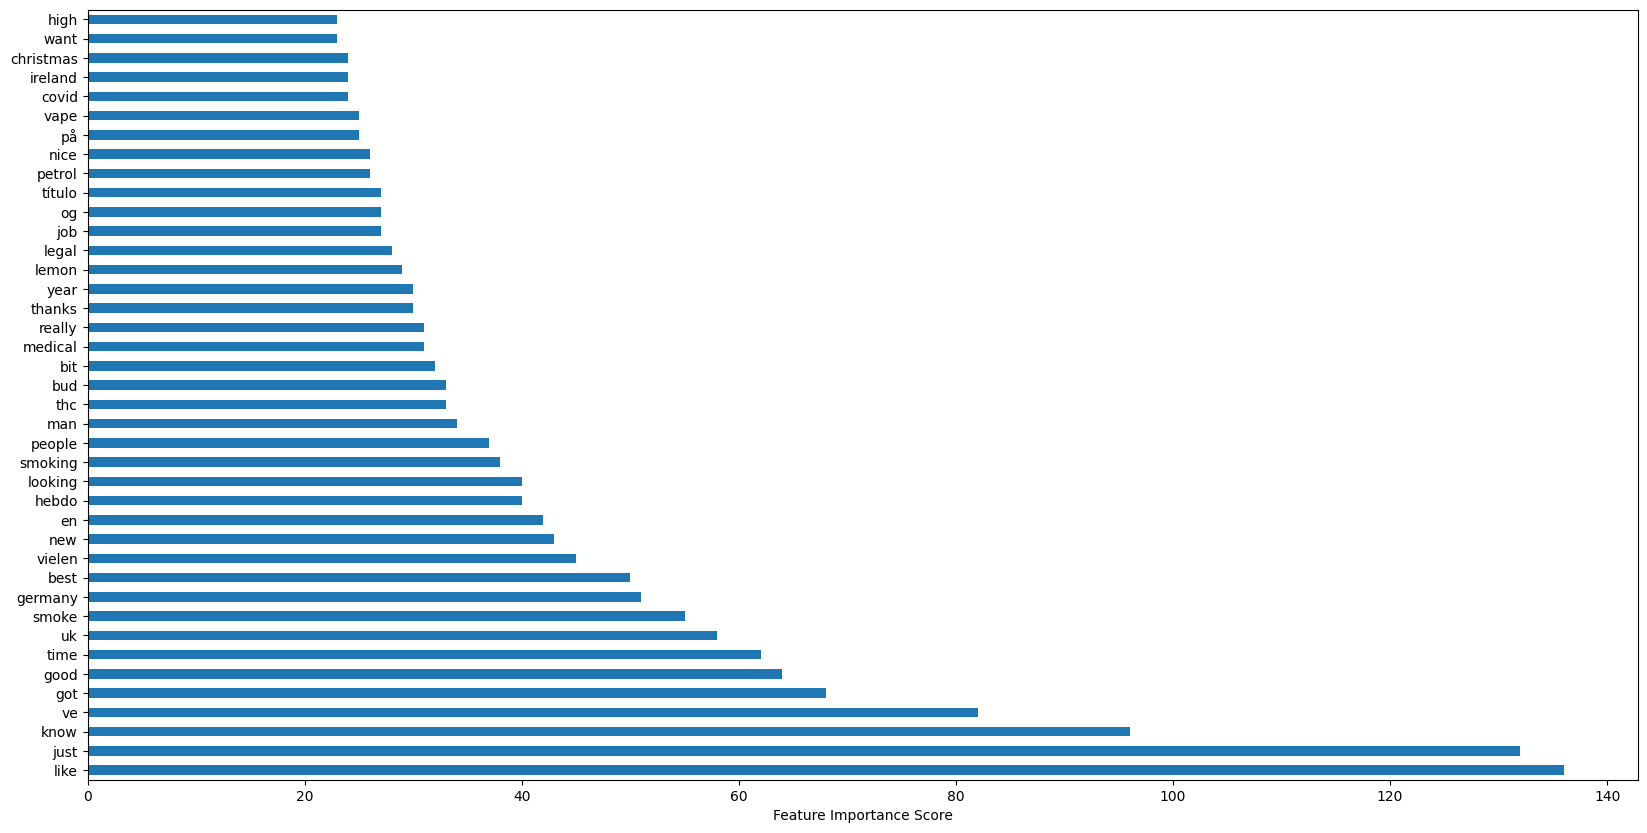

In [ ]:
feature_importance = best_model.get_booster().get_score(importance_type='weight')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

# Map feature indices to feature names
feature_names = vectorizer.get_feature_names_out()
feature_names_mapped = [feature_names[int(key[1:])] for key in keys]

# Create a DataFrame for visualization
data = pd.DataFrame(data=values, index=feature_names_mapped, columns=["score"]).sort_values(by="score", ascending=False)

# Plot the top 40 features
data.nlargest(40, columns="score").plot(kind='barh', figsize=(20, 10), legend=False)
plt.xlabel('Feature Importance Score')

In [ ]:
#not_match.to_csv(r"C:\Users\Jonathon\OneDrive\UVA\Data System Project\reddit_csv\hmm2.csv")

In [ ]:
import pandas as pd

# Assuming your DataFrame is named df and the text column is 'review_text'
no_included_samples.to_csv('/content/drive/MyDrive/reddit/reddit clean/no_include_sample_post_after_nb_xg.csv')  # Replace with the actual path to your data file


1319242

1263779

In [ ]:
# old dont use

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
import cupy as cp

# Sample data - replace this with your own dataset
texts = balanced_sample['total_no_drug'].tolist()
labels = balanced_sample['match'].tolist()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Convert text data to numerical vectors using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Create an XGBoost model with GPU support
params = {
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',  # Use GPU for tree construction
}

xgb_model = xgb.XGBClassifier(**params)

# Fit the model on the training data
xgb_model.fit(X_train_vec, y_train)

# Make predictions on the test data
y_pred = xgb_model.predict(X_test_vec)

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall}')

# Define parameter grid for grid search
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='recall', cv=3)

# Fit the grid search on the training data
grid_search.fit(X_train_vec, y_train)

# Get the best parameters and the best model from the grid search
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test data using the tuned model
y_pred_tuned = best_model.predict(X_test_vec)

# Calculate recall for the tuned model
recall_tuned = recall_score(y_test, y_pred_tuned)
print(f'Tuned Recall: {recall_tuned}')

# Use CuPy for GPU-accelerated prediction
no_sample_pre = no_included_samples['total_text'].tolist()
no_sample_pre_vec = vectorizer.transform(no_sample_pre)
check = cp.array(best_model.predict(no_sample_pre_vec))
no_included_samples['xg_boost'] = check.get()

# Display results
not_match = no_included_samples[no_included_samples['match'] != no_included_samples['xg_boost']]
not_match = not_match[not_match['match'] != 1]
not_match
